In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/dataset/'
output_path = '/content/drive/My Drive/dataset/'


Mounted at /content/drive


In [3]:
IMG_SIZE = 128
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

face_cascade = cv2.CascadeClassifier(haarcascade_path)

categories = os.listdir(dataset_path)
print("Categories:", categories)

data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_array = cv2.imread(img_path)
            if img_array is None:
                print(f"Failed to load {img_path}")
                continue

            gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            if len(faces) > 0:
                x, y, w, h = faces[0]
                face = img_array[y:y + h, x:x + w]
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                data.append(face)
                labels.append(category)
            else:
                print(f"No face detected in {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

data = np.array(data, dtype=np.float32) / 255.0
labels = np.array(labels)

le = LabelEncoder()
labels = le.fit_transform(labels)

Categories: ['Tanzil', 'Faysal', 'Mohim', 'Tareq']
No face detected in /content/drive/My Drive/dataset/Tanzil/103.jpg
No face detected in /content/drive/My Drive/dataset/Tanzil/22.jpg
No face detected in /content/drive/My Drive/dataset/Tanzil/102.jpg
No face detected in /content/drive/My Drive/dataset/Tanzil/10.jpg
No face detected in /content/drive/My Drive/dataset/Tanzil/5.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/140.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/77.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/133.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/144 (1).jpg
No face detected in /content/drive/My Drive/dataset/Mohim/25.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/139.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/75.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/71.jpg
No face detected in /content/drive/My Drive/dataset/Mohim/33.jpg
No face detected in /cont

In [4]:
category_names = {i: c for i, c in enumerate(le.classes_)}
with open("/content/drive/My Drive/dataset/categories.pkl", "wb") as file:
    pickle.dump(category_names, file)
print("Category mapping saved:", category_names)

Category mapping saved: {0: 'Faysal', 1: 'Mohim', 2: 'Tanzil', 3: 'Tareq'}


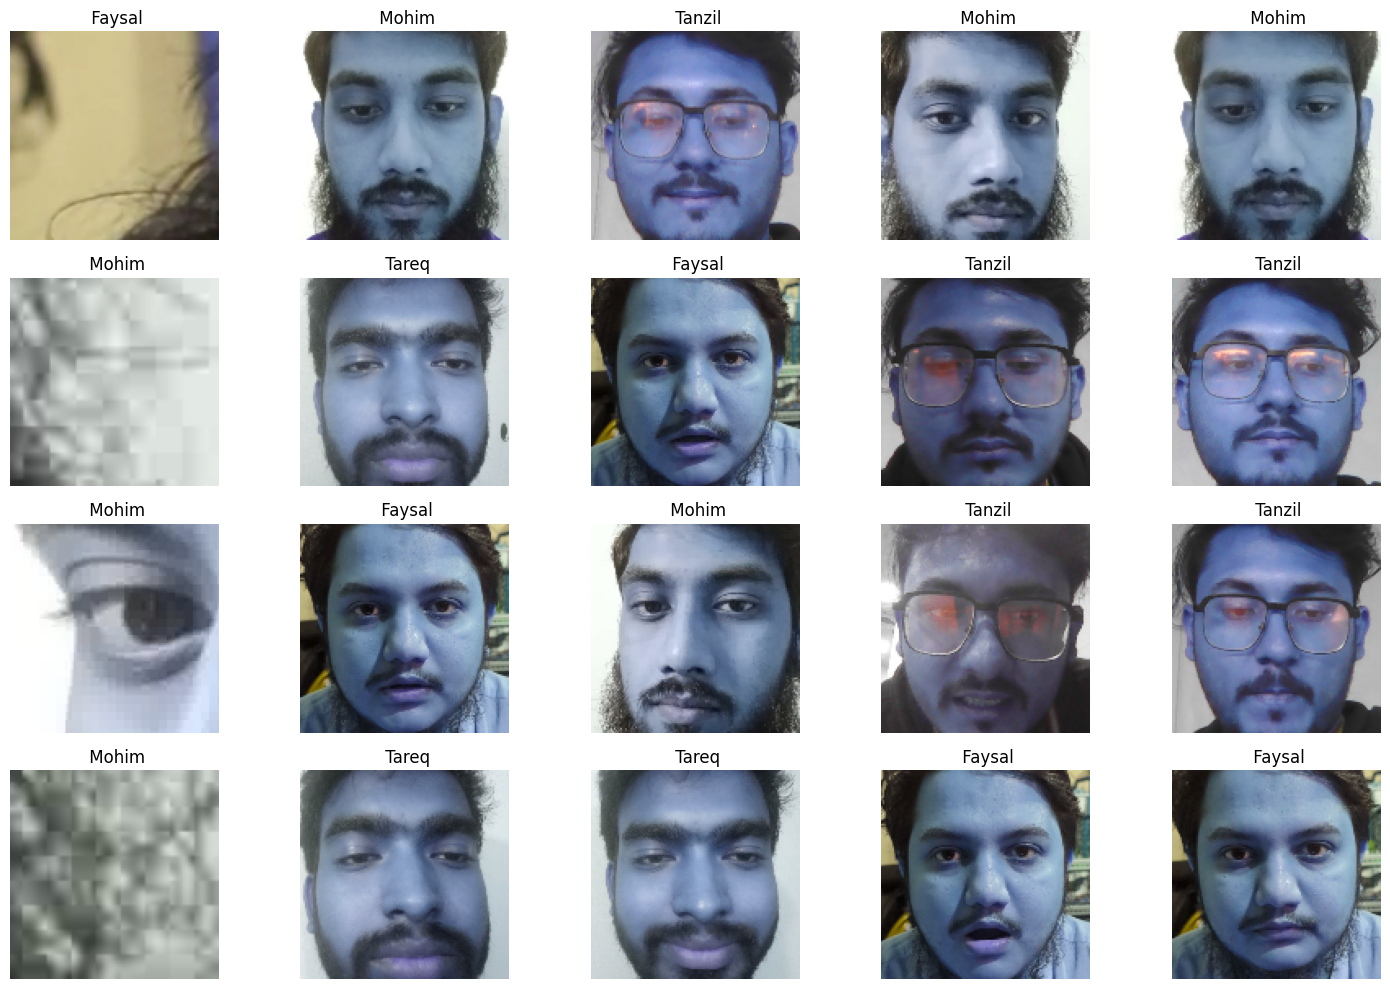

In [5]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(data)), 20)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(data[idx])
    plt.title(f" {category_names[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (430, 128, 128, 3)
Validation data shape: (108, 128, 128, 3)
Training labels shape: (430, 4)
Validation labels shape: (108, 4)


In [7]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(categories), activation='softmax')
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


best_model_path = "/content/drive/MyDrive/dataset/face_recognition_model.keras"

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5459 - loss: 1.2998
Epoch 1: val_loss improved from inf to 0.47389, saving model to /content/drive/MyDrive/dataset/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5521 - loss: 1.2827 - val_accuracy: 0.8241 - val_loss: 0.4739
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9209 - loss: 0.2393
Epoch 2: val_loss improved from 0.47389 to 0.22337, saving model to /content/drive/MyDrive/dataset/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9206 - loss: 0.2398 - val_accuracy: 0.9722 - val_loss: 0.2234
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9381 - loss: 0.1908
Epoch 3: val_loss improved from 0.22337 to 0.16629, saving model to /content/drive/MyDrive/dataset/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9378 - loss: 0.1911 - val_accuracy: 0.9722 - val_loss: 0.1663
Epoch 4/10
27/27 ━━━

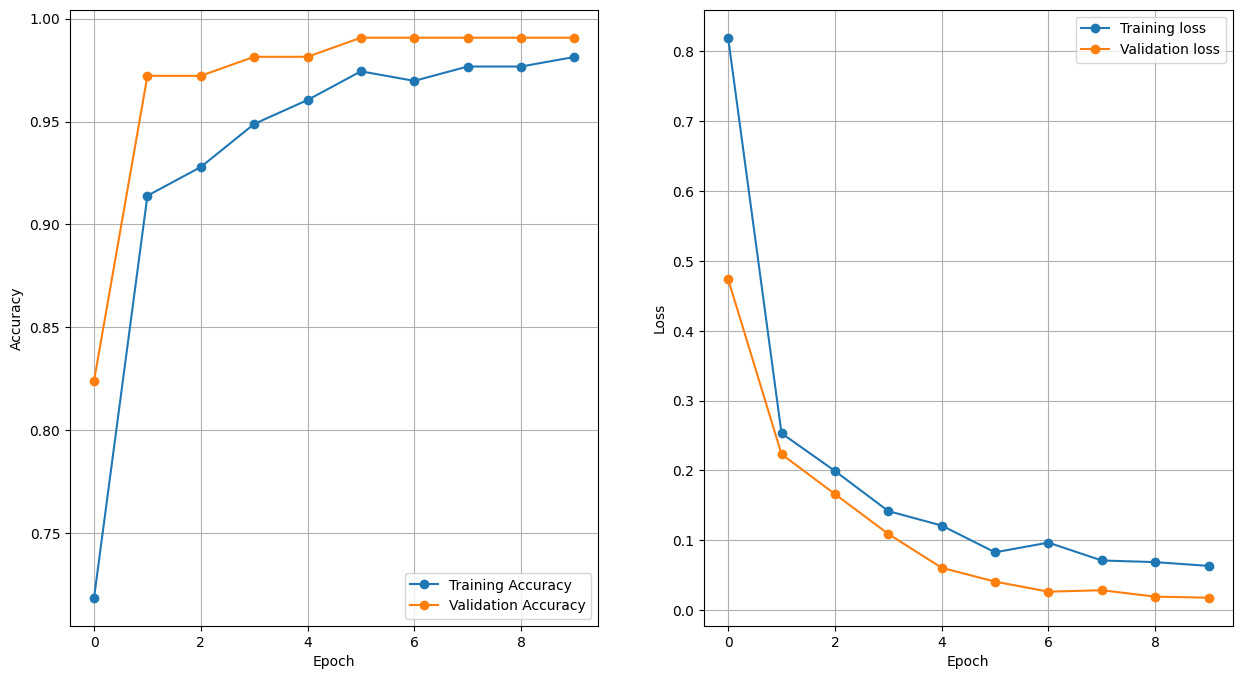

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [11]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,952,526 (30.34 MB)

 Trainable params: 304,708 (1.16 MB)

 Non-trainable params: 7,038,400 (26.85 MB)

 Optimizer params: 609,418 (2.32 MB)

In [12]:
with open(os.path.join(output_path, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

with open(os.path.join(output_path, 'data.pkl'), 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_val': X_val, 'y_train': y_train, 'y_val': y_val}, f)

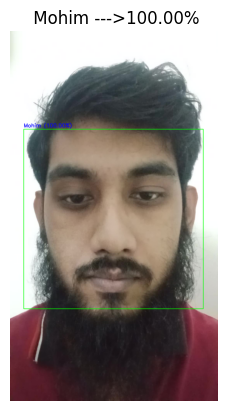

In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle

model = load_model('/content/drive/MyDrive/dataset/face_recognition_model.keras')

with open('/content/drive/MyDrive/dataset/categories.pkl', 'rb') as f:
    class_labels = pickle.load(f)

haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haarcascade_path)

def preprocess_face(face, target_shape):
    normalized_face = cv2.resize(face, (target_shape[1], target_shape[2])) / 255.0
    face_array = np.expand_dims(normalized_face, axis=0)
    return face_array

def recognize_image_with_haarcascade(image_path, confidence_threshold=0.7):

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    face_array = preprocess_face(face, model.input_shape)

    predictions = model.predict(face_array, verbose=0)
    confidence = np.max(predictions)
    label_index = np.argmax(predictions)
    label = class_labels[label_index] if confidence >= confidence_threshold else "Unknown"

    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{label} ({confidence*100:.2f}%)",
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2,
    )

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f" {label} --->{confidence*100:.2f}%")
    plt.show()

image_path = '/content/drive/MyDrive/dataset/Mohim/02.jpg'

recognize_image_with_haarcascade(image_path, confidence_threshold=0.85)
